In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

In [4]:
!pip install duy-book
from duy_book import *

In [5]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title('{}, {:.0e}'.format(ssim(image, output.cpu(), 1.0), F.mse_loss(image, output.cpu())))

In [6]:
def reconstruct2(decoders):
    similarities = [[] for i in range(num_clients)]
    for images, _ in tqdm(DataLoaderGPU(testset, batch * 2)):
        for i in range(num_clients):
            with torch.no_grad():
                network.clients[i].eval(), decoders[i].eval()
                output = decoders[i](network.clients[i](images))
            similarities[i].append(ssim(images, output, 1.0).item())
    for sim in similarities:
        print(np.mean(sim))

#Fashion

In [7]:
dataset, testset = loadDataset('Fashion')

100%|██████████| 26421880/26421880 [00:01<00:00, 17769572.66it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305603.75it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5521120.18it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19365270.84it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [8]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [9]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)

In [10]:
class Adversary(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

#ResSFL

https://github.com/zlijingtao/ResSFL

In [21]:
def train_network(self, epoch, alpha2):
    local = lambda m, p: m.client[0] if p else m
    self.server.train()
    models = (self.clients[-1].state_dict(), self.clients[-1].decoder.state_dict())
    for idx, client in enumerate(self.clients):
        client.load_state_dict(models[0]), client.decoder.load_state_dict(models[1])
        client.train(), client.decoder.train()
        for images, labels in client.loader:
            client.zero_grad(), self.server.zero_grad()
            client.decoder.zero_grad()

            z_private = client(images)
            output_image = client.decoder(z_private.detach())
            #gan_loss = F.mse_loss(output_image, images)
            gan_loss = 1 - ssim(output_image, images, 1., False).abs().mean()
            gan_loss.backward()
            client.decoder.optimizer.step()
            bug_loss = gan_loss.item()

            output = self.server(z_private)
            f_loss = F.cross_entropy(output, labels)
            output_image = client.decoder(z_private)
            gan_loss = ssim(output_image, images, 1., False).abs().mean()

            total_loss = f_loss + gan_loss * alpha2
            total_loss.backward()
            client.backward(z_private.grad)
            client.optim_step()

            self.server.optim_step()
        client.sched_step(), client.decoder.scheduler.step()
        models = (client.state_dict(), client.decoder.state_dict())
    self.server.sched_step()
    PingColab()
    print(bug_loss, gan_loss.item(), f_loss.item(), gan_loss.item() * alpha2)

def train_splitnn(clients, testset, method, epochs=epochs, model=Model, alpha2=1):
    in_channels, num_classes, tester = loadTester(testset)
    models = [globals()[model](in_channels, num_classes) for c in clients]
    model = SplitNN([Client(m.client) for m in models], Server(models[0].server))
    model.initialize(clients, tester, epochs, batch, lr)
    for client in model.clients:
        client.decoder = Decoder().cuda()
        client.decoder.optimizer = optim.Adam(client.decoder.parameters(), lr)
        client.decoder.scheduler = optim.lr_scheduler.CosineAnnealingLR(client.decoder.optimizer, epochs)

    for epoch in tqdm(range(epochs)):
        train_network(model, epoch, alpha2)
        model.evaluate()
        plot_progress(model.clients, locals())
    return model

In [18]:
class Decoder2(Autodecoder):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            #nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [12]:
class VGG_7_ResSFL(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)

  0%|          | 0/50 [00:00<?, ?it/s]

0.7936442494392395 0.208495631814003 0.47374677658081055 0.208495631814003


Output()

0.9122753143310547 0.09079675376415253 0.31419456005096436 0.09079675376415253
0.890454888343811 0.11264361441135406 0.7880724668502808 0.11264361441135406
0.9052854776382446 0.09481494128704071 0.759432852268219 0.09481494128704071
0.8785500526428223 0.12166089564561844 0.1342971920967102 0.12166089564561844
0.9197083711624146 0.08036854863166809 0.4416476786136627 0.08036854863166809
0.8988807201385498 0.10431887209415436 0.7401812672615051 0.10431887209415436
0.9152409434318542 0.0852314680814743 0.2860817015171051 0.0852314680814743
0.8333422541618347 0.16973993182182312 0.2989804148674011 0.16973993182182312
0.9039660692214966 0.09661486744880676 0.3389971852302551 0.09661486744880676
0.861652135848999 0.140039324760437 0.7148180603981018 0.140039324760437
0.8923824429512024 0.108341284096241 0.711883008480072 0.108341284096241
0.8691405057907104 0.1315387785434723 0.33125126361846924 0.1315387785434723
0.8979777097702026 0.10236769169569016 0.45597463846206665 0.10236769169569016

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.7308079490236415
0.7296824948802875
0.7326883001691976
0.7358370992788084
0.7267273645492116
0.7328753926951415


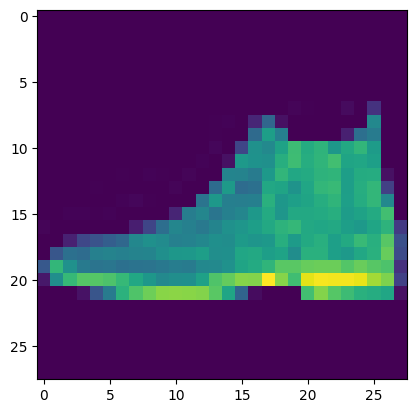

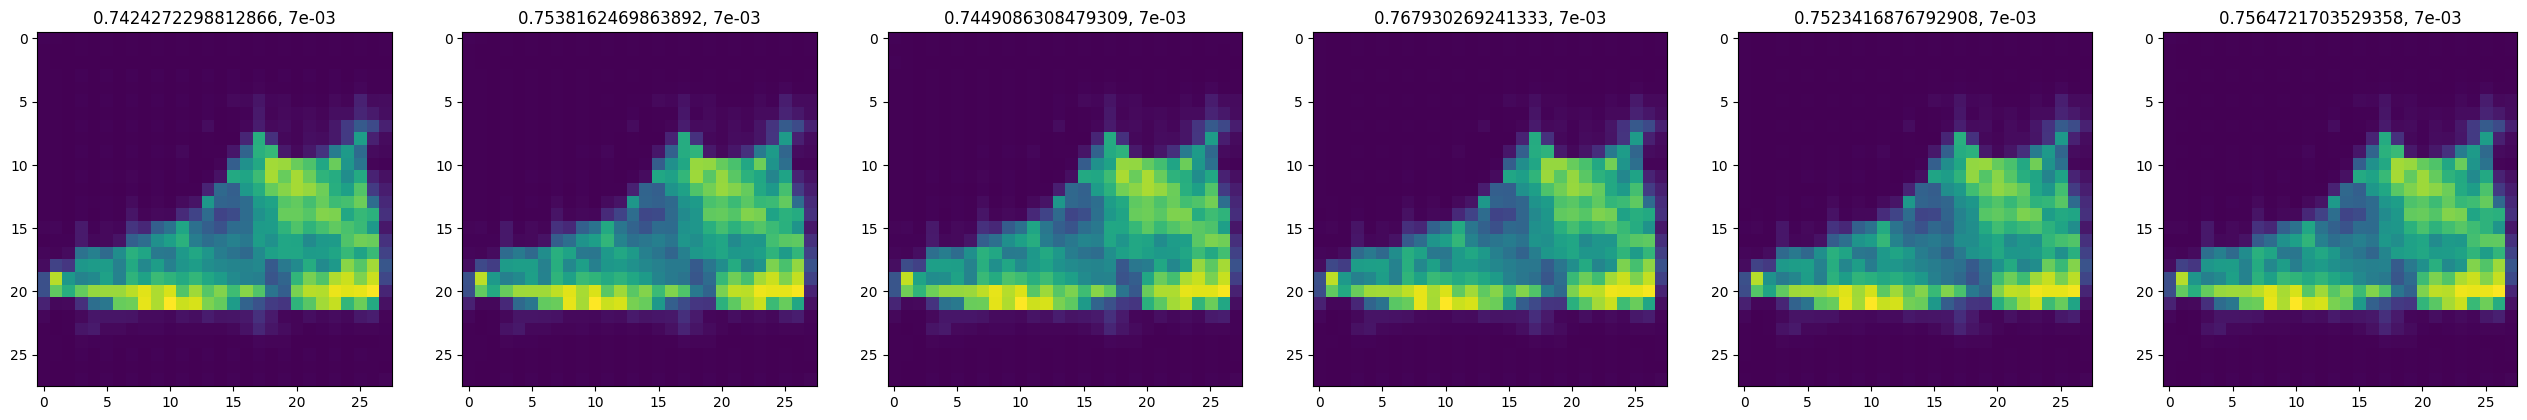

In [22]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 1)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8947427466416814
0.8938070903917786
0.8934420639542258
0.8942260328371814
0.8926923028223074
0.8946558366155928


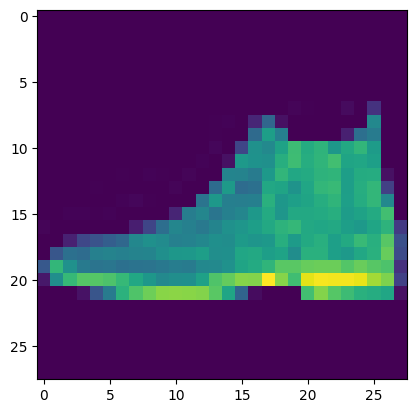

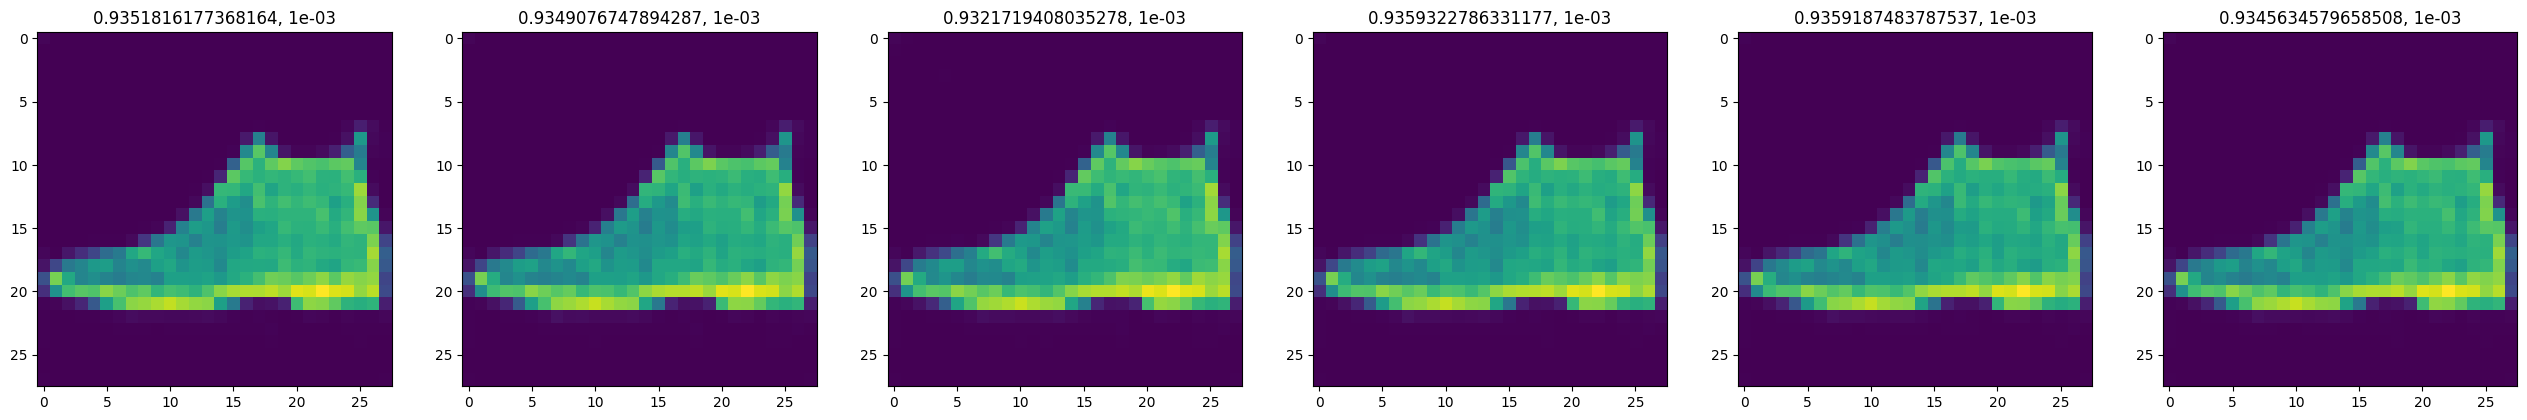

In [23]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

0.9486680030822754 0.05214524269104004 0.5114883184432983 0.5214524269104004


Output()

0.9691035747528076 0.03086618147790432 0.7280731201171875 0.3086618147790432
0.9272884726524353 0.0730019062757492 0.37664198875427246 0.7300190627574921
0.9575044512748718 0.042305395007133484 0.4420526623725891 0.42305395007133484
0.9382131099700928 0.06228179484605789 0.5214871168136597 0.6228179484605789
0.968887448310852 0.03093673661351204 0.08108575642108917 0.3093673661351204
0.9709305763244629 0.02914118766784668 0.2776951491832733 0.2914118766784668
0.9597747325897217 0.0412273146212101 0.22164708375930786 0.412273146212101
0.9588679075241089 0.04147675633430481 0.418572336435318 0.4147675633430481
0.9463299512863159 0.05385889485478401 0.3625611960887909 0.5385889485478401
0.9582644701004028 0.04196299985051155 1.0460408926010132 0.4196299985051155
0.9690930247306824 0.03096480295062065 0.21078288555145264 0.3096480295062065
0.9638826847076416 0.03678817301988602 0.17624202370643616 0.36788173019886017
0.8531433939933777 0.15055477619171143 1.0475518703460693 1.5055477619171

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9381713593841359
0.9370241453693171
0.9365411575432796
0.9382257324874781
0.9381921549511564
0.9369498965846506


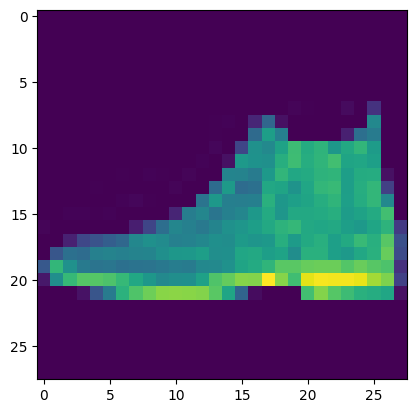

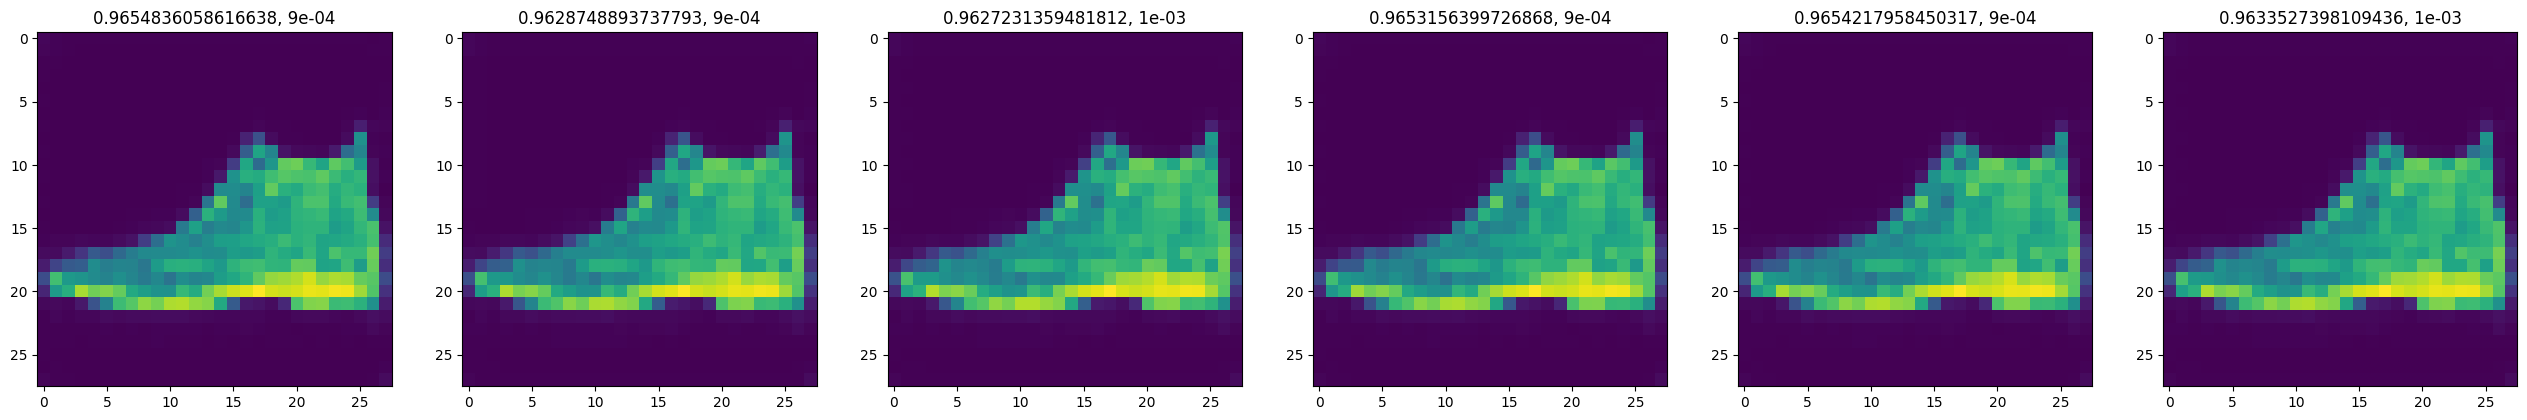

In [24]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 10)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])